In [1]:
from paretoKnapsackInfluence import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

# Import influence datasets
data_path_HEPT = '../../datasets/raw_data/influence/NetHEPT/hep.txt'
data_path_PHY = '../../datasets/raw_data/influence/NetPHY/phy.txt'

G_HEPT, node_costs_HEPT = import_influence_data(data_path_HEPT)
G_PHY, node_costs_PHY = import_influence_data(data_path_PHY)

2026-02-04 15:24:07,943 |INFO: Imported influence graph with 169 nodes and 793 edges
2026-02-04 15:24:09,207 |INFO: Imported influence graph with 151 nodes and 735 edges


In [2]:
def findApproximateParetoSolutionsKnapsackInfluence(G, node_costs, maxBudget, num_samples=35, num_runs=10, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Influence vs Cost).
    Parameters:
    - G: Graph
    - node_costs: Node costs dict
    - maxBudget: Maximum knapsack budget
    - num_samples: Number of Monte Carlo samples per run
    - num_runs: Number of independent runs
    - dataset_name: Name of the dataset for plotting
    '''
    # Cost grid (same pattern as restaurants notebook)
    num_steps, min_cost = 10, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    all_algo_names = ["C-Greedy", "C-Greedy-1", "ParetoGreedy", "F-Greedy", "TopK"]
    plot_algos = {
        "C-Greedy": True,
        "C-Greedy-1": True,
        "ParetoGreedy": True,
        "F-Greedy": True,
        "TopK": True
    }
    algo_names = [alg for alg in all_algo_names if plot_algos.get(alg, False)]

    # containers across runs
    all_influences = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_costs_all = []
    pareto_points_counts = []

    for _ in range(num_runs):

        # Generate graph samples once to share across algorithms (per run)
        graph_samples = []
        for _ in range(num_samples):
            G_sample = nx.Graph()
            neighbors = defaultdict(set)
            connected_components = defaultdict()
            for u, v, data in G.edges(data=True):
                success = np.random.uniform(0, 1)
                if success < data['weight']:
                    G_sample.add_edge(u, v)
                    neighbors[u].add(v)
                    neighbors[v].add(u)
            for c in nx.connected_components(G_sample):
                for node in c:
                    connected_components[node] = c
            graph_samples.append((G_sample, neighbors, connected_components))

        run_influences = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # Run algorithms over budgets
        for budgetVal in cost_arr:
            pareto = paretoKnapsackInfluence(G=G,
                                             node_costs=node_costs,
                                             budget=budgetVal,
                                             num_samples=num_samples,
                                             graph_samples=graph_samples)

            # Plain Greedy (C-Greedy)
            if "C-Greedy" in algo_names:
                plain_nodes, infl, cost, runTime = pareto.plainGreedy()
                run_influences['C-Greedy'].append(infl)
                run_runtimes['C-Greedy'].append(runTime)
            else:
                plain_nodes = []

            # One Guess Greedy Plus (C-Greedy-1)
            if "C-Greedy-1" in algo_names:
                _, infl, cost, runTime = pareto.oneGuessGreedyPlus()
                run_influences['C-Greedy-1'].append(infl)
                run_runtimes['C-Greedy-1'].append(runTime)

            # Top-k (add nodes until budget is hit)
            if "TopK" in algo_names:
                _, infl, cost, runTime = pareto.top_k()
                run_influences['TopK'].append(infl)
                run_runtimes['TopK'].append(runTime)

        # Pareto Greedy + Coverage Linear (computed once per run at full budget)
        if "ParetoGreedy" in algo_names or "F-Greedy" in algo_names:
            pareto_full = paretoKnapsackInfluence(G=G,
                                                  node_costs=node_costs,
                                                  budget=maxBudget,
                                                  num_samples=num_samples,
                                                  graph_samples=graph_samples)
        else:
            pareto_full = None

        if "ParetoGreedy" in algo_names:
            pg1_costs, pg1_influences, _, pg1_time = pareto_full.prefixParetoGreedy_1Guess()
        else:
            pg1_costs, pg1_influences, pg1_time = [], [], 0.0

        if "F-Greedy" in algo_names:
            cl_costs, cl_influences, _, cl_time = pareto_full.F_Greedy()
        else:
            cl_costs, cl_influences, cl_time = [], [], 0.0
        # pg2_costs, pg2_influences, _, pg2_time = pareto_full.prefixParetoGreedy_2Guess()

        # Align pareto curves to cost_arr by interpolation
        def align_to_cost_arr(costs, infls):
            if len(costs) == 0:
                return np.zeros_like(cost_arr, dtype=float)
            costs = np.array(costs)
            infls = np.array(infls)
            return np.interp(cost_arr, costs, infls, left=infls[0], right=infls[-1])

        if "ParetoGreedy" in algo_names:
            run_influences['ParetoGreedy'] = list(align_to_cost_arr(pg1_costs, pg1_influences))
            run_runtimes['ParetoGreedy'].append(pg1_time)
            pareto_costs_all.extend(pg1_costs)
            pareto_points_counts.append(len(pg1_costs))

        if "F-Greedy" in algo_names:
            run_influences['F-Greedy'] = list(align_to_cost_arr(cl_costs, cl_influences))
            run_runtimes['F-Greedy'].append(cl_time)
        # run_influences['ParetoGreedy-2'] = list(align_to_cost_arr(pg2_costs, pg2_influences))
        # run_runtimes['ParetoGreedy-2'].append(pg2_time)

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_influences[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_influences[alg].append(arr)
            total_runtime = float(np.nansum(np.array(run_runtimes.get(alg, []), dtype=float))) if len(run_runtimes.get(alg, [])) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

    # compute mean and std across runs for each algorithm
    mean_influences = {}
    std_influences = {}
    dataset_key = (dataset_name or "").upper()

    for alg in algo_names:
        stacked = np.vstack(all_influences[alg])  # shape (num_runs, len(cost_arr))
        mean_influences[alg] = np.mean(stacked, axis=0)
        std_influences[alg] = np.std(stacked, axis=0) * 0.75

    mean_pareto_points = int(np.round(np.mean(pareto_points_counts))) if len(pareto_points_counts) > 0 else 0
    if mean_pareto_points < 1:
        mean_pareto_points = 1

    # Plot mean influence with shaded std band (consistent with teams formatting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[0],
        "F-Greedy": tab10_colors[1],
        "C-Greedy": tab10_colors[2],
        "C-Greedy-1": tab10_colors[3],
        "ParetoGreedy": tab10_colors[4],
    }
    marker_map = {
        "TopK": "o",
        "F-Greedy": "s",
        "C-Greedy": "^",
        "C-Greedy-1": "v",
        "ParetoGreedy": "X",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "F-Greedy": (0, (2, 2)),
        "C-Greedy": (0, (3, 2)),
        "C-Greedy-1": (0, (1, 2)),
        "ParetoGreedy": (0, (4, 2)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    label_map = {}
    pareto_legend_handle = None
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_influences[alg]
        std = std_influences[alg]
        is_pareto = alg in {"ParetoGreedy"}
        marker_size = 7 if is_pareto else 6
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        if alg == "ParetoGreedy":
            zorder = 4

        label = rf"\texttt{{{alg}}}"
        label_map[alg] = label
        if is_pareto:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            pareto_costs_unique = np.unique(np.array(pareto_costs_all, dtype=float))
            pareto_costs_unique = pareto_costs_unique[(pareto_costs_unique >= cost_arr.min()) & (pareto_costs_unique <= cost_arr.max())]
            if pareto_costs_unique.size > 0:
                keep_count = max(1, int(np.ceil(pareto_costs_unique.size * 0.75)))
                keep_idx = rng.choice(pareto_costs_unique.size, size=keep_count, replace=False)
                pareto_costs_unique = np.sort(pareto_costs_unique[keep_idx])
                min_sep = 0.5 * (cost_arr[1] - cost_arr[0]) if cost_arr.size > 1 else 0
                filtered_costs = [pareto_costs_unique[0]]
                for c in pareto_costs_unique[1:]:
                    if c - filtered_costs[-1] >= min_sep:
                        filtered_costs.append(c)
                pareto_costs_unique = np.array(filtered_costs, dtype=float)
            pareto_mean_vals = np.interp(pareto_costs_unique, cost_arr, mean)
            ax.scatter(pareto_costs_unique, pareto_mean_vals,
                       label="_nolegend_",
                       color=color,
                       marker=marker,
                       s=marker_size**2,
                       edgecolor='k',
                       linewidths=0.6,
                       zorder=zorder + 1)
            if alg == "ParetoGreedy":
                from matplotlib.lines import Line2D
                pareto_legend_handle = Line2D([0], [0],
                                              color=color,
                                              linestyle=line_style,
                                              marker=marker,
                                              markersize=marker_size,
                                              markeredgewidth=1.1,
                                              markeredgecolor='k',
                                              linewidth=1.8)
        else:
            ax.plot(cost_arr, mean,
                    label=label,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=1.1,
                    markeredgecolor='k',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Seed cost, $c_\ell$', fontsize=28)
    ax.set_ylabel(r'Expected influence, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Legend (saved separately) - handled in teams notebook
    # handles, labels = ax.get_legend_handles_labels()
    # if handles:
    #     handle_map = dict(zip(labels, handles))
    #     pareto_label = label_map.get("ParetoGreedy")
    #     if pareto_label and pareto_legend_handle is not None:
    #         handle_map[pareto_label] = pareto_legend_handle
    #     ordered_labels = [
    #         label_map["F-Greedy"],
    #         label_map["ParetoGreedy"],
    #         label_map["C-Greedy"],
    #         label_map["C-Greedy-1"],
    #         label_map["TopK"],
    #     ]
    #     ordered_handles = [handle_map[l] for l in ordered_labels if l in handle_map]

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    # Save legend as separate PDF (only once)
    # if handles:
    #     legend_out_path = plots_dir / "knapsack_legend_influence.pdf"
    #     if not legend_out_path.exists():
    #         legend_fig = plt.figure(figsize=(8, 2))
    #         legend_fig.legend(ordered_handles, ordered_labels, loc='center', ncol=3, fontsize=20, frameon=True)
    #         legend_fig.savefig(legend_out_path, bbox_inches="tight")
    #         plt.close(legend_fig)

    plt.show()

    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    print("\n".join(runtime_lines))

### NetHEPT Experiments

In [3]:
# Parameters
maxBudget = 150
num_samples = 3
num_runs = 3

2026-02-04 15:24:09,281 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=1.0
2026-02-04 15:24:09,285 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=17.555555555555557
2026-02-04 15:24:10,094 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=34.111111111111114
2026-02-04 15:24:12,629 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=50.66666666666667
2026-02-04 15:24:17,741 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=67.22222222222223
2026-02-04 15:24:25,375 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=83.77777777777779
2026-02-04 15:24:36,007 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=100.33333333333334
2026-02-04 15:24:50,077 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:169, Budget=116.8888888888889
202

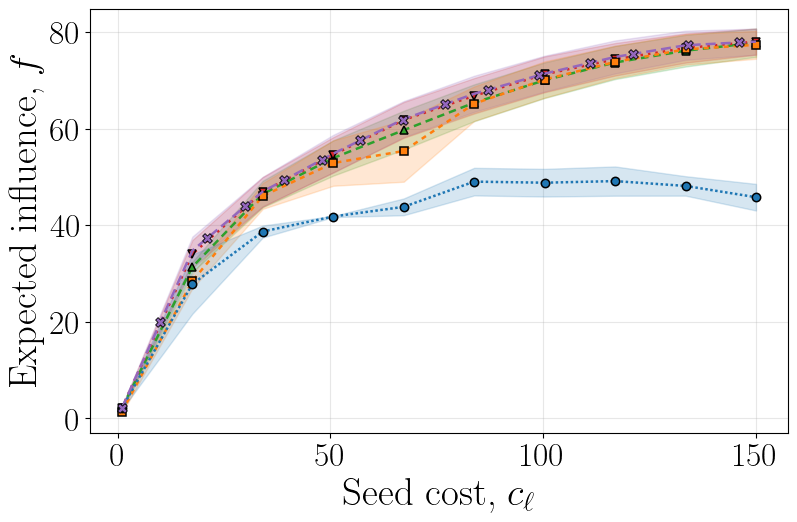

Runtime summary (mean ± std, seconds):
  - C-Greedy: 0.059 ± 0.003
  - C-Greedy-1: 92.739 ± 3.230
  - ParetoGreedy: 1.019 ± 0.056
  - F-Greedy: 0.277 ± 0.005
  - TopK: 0.018 ± 0.000


In [4]:
# Run for NetHEPT
findApproximateParetoSolutionsKnapsackInfluence(
    G_HEPT,
    node_costs_HEPT,
    maxBudget,
    num_samples=num_samples,
    num_runs=num_runs,
    dataset_name="NetHEPT"
)

### NetPHY Experiments

2026-02-04 15:28:52,255 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=1.0
2026-02-04 15:28:52,262 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=17.555555555555557
2026-02-04 15:28:53,109 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=34.111111111111114
2026-02-04 15:28:55,456 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=50.66666666666667
2026-02-04 15:28:59,816 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=67.22222222222223
2026-02-04 15:29:06,029 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=83.77777777777779
2026-02-04 15:29:14,194 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=100.33333333333334
2026-02-04 15:29:23,737 |INFO: Initialized Pareto Influence - Knapsack Cost Instance, Num Nodes:151, Budget=116.8888888888889
202

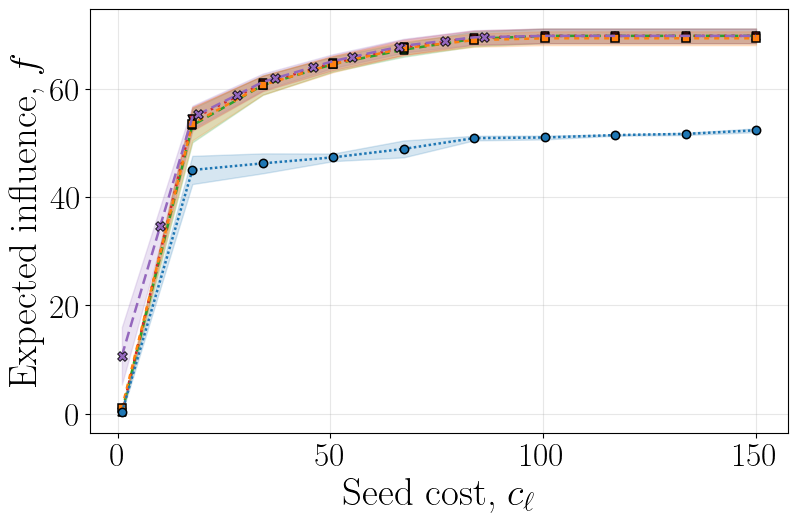

Runtime summary (mean ± std, seconds):
  - C-Greedy: 0.058 ± 0.004
  - C-Greedy-1: 67.745 ± 5.028
  - ParetoGreedy: 0.703 ± 0.090
  - F-Greedy: 0.188 ± 0.013
  - TopK: 0.016 ± 0.000


In [5]:
# Run for NetPHY
findApproximateParetoSolutionsKnapsackInfluence(
    G_PHY,
    node_costs_PHY,
    maxBudget,
    num_samples=num_samples,
    num_runs=num_runs,
    dataset_name="NetPHY"
)